# ARGO Winter Project: RadRoads

## Author: Yuwen Chang

## Coded in Python 3

## Objective
In a given area, identify:
1. Longest Road
2. Shortest Road
3. Straightest Road
4. Curviest Road

## Properties

`ox.graph_from_xxx` returns a [MultiDiGraph](https://networkx.github.io/documentation/networkx-1.10/reference/classes.multidigraph.html) (Directed graphs with self loops and parallel edges)

Edge attributes include:
- osmid: key in OSM
- name: road name
- highway: road type
- oneway (Boolean): one-way road (or not)
- length: road length (meters)

## NYC
- Entire city
- Zip code
- Neighborhood

# Next Steps

1. Review [Geo-Street-Talk-Global](https://github.com/Streets-Data-Collaborative/geo-street-talk-global)
    - Does the ReadMe provide enough information for you to get started?
    - Is the code well commented?
    - Can any sections of code be cleaned up or made more modular?
    - What extensions can you think of to make the project more useful?

2. Introduce improvements
    - Use Sinuosity as a measure instead of Circuity. [geopandas implementation](https://github.com/Geosyntec/gisutils/blob/a4034d5dfed472588548306860d010b3dd99a980/gisutils/algo.py)
    - Apply filters for results (e.g., longest, shortest)
    - Merge a single RadRoads() function that shows the following for each input city with :
        - Longest Segment [Red]
        - Shortest Segment [Blue]
        - Straightest Segment [Green]
        - Most Sinusoisal segment aka Curviest [Yellow]
    - [Index based on Name and From-To Nodes](https://www.openstreetmap.org/way/260042856#map=17/40.01316/-105.28674&layers=D): OSM contains `Node` information for every `Way` and this can be used to identify, spatially, the street segments.
    - [Colorize street types](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
    - Insert Google map interactive window

3. Polish notebooks and fix in-notebook issues

4. Blog post on current results

5. Think in the [larger context](https://github.com/Streets-Data-Collaborative/Autonomous_Transportation_Analyzer) and plan for the next

6. Other things to ponder:
    - How to utilize this characteristics to evaluate ride/walk/street quality, preparedness of AV of a city, etc.?
    - Create a profile for road network characteristics that can be compared worldwide. Maybe a regional view is more meaningful than identifying a single street (longest, straightest)?
    - Other examples: identifying straightest roads between two points can be used to ask "which city has the straightest connections between CBD and populated residential areas?"

7. Random notes:
    - The longest and shortest street may turn out to be highways: filtering; avoid 'Motorway' in our outcome?
    - Group by names: may combine two different streets with same name: verify whether all segments of a road is connected; segs of a same road shares the same OSMid?; add new street index besides street name: OSM nodes from, OSM nodes to. i.e: Street name OSM nodes from-OSM nodes to
    - Shp file does not have the double edges (length doubled for two-way roads) problem?
    - Other attributes that might be good to look into: direction, width?

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import osmnx as ox
import networkx as nx
import geopandas as gpd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Sandbox for longest/shortest road
## 1.1 Create a road segment dataframe

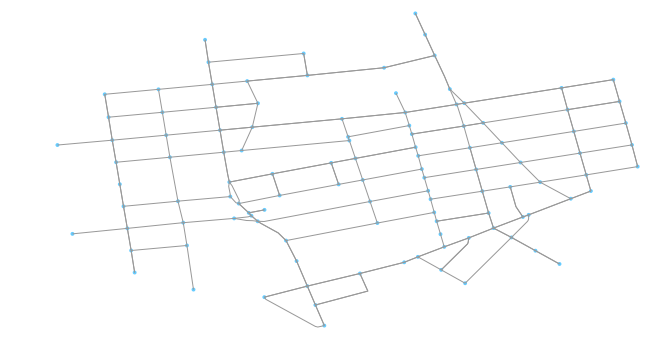

(<matplotlib.figure.Figure at 0x134c8a470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x134c8af28>)

In [382]:
# import a small area as sandbox
G = ox.graph_from_address('201 Moore St, Brooklyn, NY', distance=1000,
                          distance_type='network', network_type='drive')
ox.plot_graph(G)

In [383]:
# calculate basic stats of the graph
basic_stats = ox.basic_stats(G)
extended_stats = ox.extended_stats(G, bc=True)

basic_stats

{'circuity_avg': 1.0049939671911123,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None,
 'edge_density_km': None,
 'edge_length_avg': 100.89336467742474,
 'edge_length_total': 24819.767710646487,
 'intersection_count': 109,
 'intersection_density_km': None,
 'k_avg': 4.4324324324324325,
 'm': 246,
 'n': 111,
 'node_density_km': None,
 'self_loop_proportion': 0.0,
 'street_density_km': None,
 'street_length_avg': 103.19392438192935,
 'street_length_total': 17336.579296164131,
 'street_segments_count': 168,
 'streets_per_node_avg': 10.72972972972973,
 'streets_per_node_counts': {0: 0, 1: 14, 2: 0, 3: 153, 4: 177, 5: 2},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.12612612612612611,
  2: 0.0,
  3: 1.3783783783783783,
  4: 1.5945945945945945,
  5: 0.018018018018018018}}

In [384]:
# check data structure for each edge (road segment)
segs = list(G.edges(data=True))
segs[0]

(42466686,
 42466688,
 {'highway': 'residential',
  'length': 42.743512009832763,
  'name': 'Bushwick Court',
  'oneway': False,
  'osmid': 5674905})

In [385]:
# pull out edge attributes as a dataframe
df = pd.DataFrame([[i[0], i[1], i[2]['highway'], i[2]['length'],
                    i[2]['name'], i[2]['oneway'], i[2]['osmid']] for i in segs],
                  columns=['node_a', 'node_b', 'type', 'length',
                           'name', 'oneway', 'osmid'])
df.head()

,node_a,node_b,type,length,name,oneway,osmid
0,42466686,42466688,residential,42.743512,Bushwick Court,False,5674905
1,42466686,42513670,secondary,42.380138,Bushwick Avenue,False,347717621
2,42466686,3539722830,secondary,12.522124,Bushwick Avenue,False,471943032
3,42466688,42466686,residential,42.743512,Bushwick Court,False,5674905
4,42467807,42467811,residential,79.154975,Graham Avenue,False,221753943


In [386]:
# check edge counts against basic stats of graph
len(df)

246

## 1.2 Combine road segments

This section is critical as it defines what we call a road. In this sandbox, a road is defined as connected segments that share a same road name.

### Issue 1: Multiple road names
Name column appears to be in list form in saome ways and needs to be converted to string type again before it can be grouped by. The problem appears to be due to some road names being coded as lists containing 2 roads, e.g., ['Forrest Street', 'Garden Street'].

In [387]:
df['name'] = df['name'].apply(lambda x: str(x))

### Issue 2: Starting and ending nodes
Current method removes all node information, a later version should identify and update the nodes for a road after the segments are combined and keep them in the dataframe.

In [388]:
# group by road names and calculate sums of lengths from all segments
# drop meaningless columns
df2 = df.groupby(by='name').sum().reset_index()
df2.drop(['node_a', 'node_b', 'oneway'], axis=1, inplace=True)
df2.head()

,name,length
0,Boerum Street,786.530527
1,Bogart Street,564.041199
2,Bushwick Avenue,2199.731455
3,Bushwick Court,85.487024
4,Bushwick Place,258.737162


In [389]:
# identify shortest roads
df2.sort_values('length', ascending=True).head()

,name,length
3,Bushwick Court,85.487024
5,Central Avenue,156.251360
31,Waterbury Street,157.800166
25,Seigel Court,158.570934
15,McKibbin Court,158.891626


In [390]:
# identify longest roads
df2.sort_values('length', ascending=False).head()

,name,length
13,Johnson Avenue,2539.938848
2,Bushwick Avenue,2199.731455
6,Flushing Avenue,1887.550640
17,Meserole Street,1387.971589
20,Morgan Avenue,1374.179454


## 1.3 Validate

### Issue 3: Ground truth mismatch

Below are the distances measured on Google Map:

- Johnson Ave. (Brooklyn, NY):
1,484 m (4,870 ft.)

- Flushing Ave. (Brooklyn, NY):
1,118 m (3,669 ft.)

- Bushwick Ave. (Brooklyn, NY):
**PROBLEMATIC: some segments are separated directionally**

- Meserole St. (Brooklyn, NY):
877 m (2,877 ft.)

- Morgan Ave. (Brooklyn, NY):
790 m (2,594 ft.)

- Bushwick Court:
37 m

- Waterbury Street:
79 m

- Seigel Court:
79 m

### The guess is that two-way roads are doubled in distance for somehow. Does not affect the results for this small area for now but should come back and fix this later.

In [391]:
# validate segement counts
df3 = df.groupby(by='name').count().reset_index()
df3.sort_values('length', ascending=False).head()

,name,node_a,node_b,type,length,oneway,osmid
2,Bushwick Avenue,31,31,31,31,31,31
6,Flushing Avenue,22,22,22,22,22,22
20,Morgan Avenue,17,17,17,17,17,17
13,Johnson Avenue,17,17,17,17,17,17
8,Graham Avenue,16,16,16,16,16,16


### Fluching Ave. for example, only has 13 segments on the map but counts for 26 in the dataframe. Also, most roads start with at least 2 segments. Try to use duplicates to solve this. However, cases with odd numbers and separate lanes will have to be addressed differently.

**Consider:** divide by two if oneway == False

## 1.4 Construct a function

In [2]:
def howlong(place, ntype='drive'):
    """
    Find the shortest and longest roads by name in a given geographical area in OSM.
    
    Args:
        1. place: a string of place name
        2. ntype: network type (not tested yet)
    Return:
        1. name and length of the shortest road (length problem unsolved)
        2. name and length of the longest road (length problem unsolved)
        3. network graph plot of given place
    """
    
    # try different API query results
    try:
        G = ox.graph_from_place(place, network_type='drive', which_result=1)
    except:
        G = ox.graph_from_place(place, network_type='drive', which_result=2)
    
    # > > > > > FUTURE: save as shapefile and read in < < < < <
    # save and read as .shp file
    ox.save_graph_shapefile(G, filename='howlong')
    G_edges = gpd.read_file('data/howlong/edges/edges.shp')
    G_nodes = gpd.read_file('data/howlong/nodes/nodes.shp')
    
    # convert road segments as df
    segs = list(G.edges(data=True))

    df = pd.DataFrame([[i[0], i[1], i[2]['highway'], i[2]['length'],
                        i[2]['name'], i[2]['oneway'], i[2]['osmid']] for i in segs if 'name' in i[2]],
                      columns=['node_a', 'node_b', 'type', 'length',
                               'name', 'oneway', 'osmid'])
    df['name'] = df['name'].apply(lambda x: str(x))

    # > > > > > FUTURE: group by osmid instead of road name < < < < <
    
    # combine road segments
    df2 = df.groupby(by='name').sum().reset_index()
    df2.drop(['node_a', 'node_b', 'oneway'], axis=1, inplace=True)
    
    # calculate shortest and longest roads
    short = df2.sort_values('length', ascending=True).head(1).iloc[0]
    long = df2.sort_values('length', ascending=False).head(1).iloc[0]

    # output
    print('Shortest road: {:s} ({:.2f} meters)'.format(short['name'], short['length']))
    print('Longest road: {:s} ({:.2f} meters)'.format(long['name'], long['length']))

    ox.plot_graph(G);
    fig, ax = pl.subplots(figsize=(10,10))
    G_edges.plot(ax=ax)
    G_edges[G_edges['name'] == short['name']].plot(color='red', ax=ax, label='shortest')
    G_edges[G_edges['name'] == long['name']].plot(color='orange', ax=ax, label='longest')
    pl.legend(fontsize='medium')
    pl.show()

### Issue 4: Missing road name

This function soon ran into a problem: some edge does not have name and throws back a key error. This is handled by only extracting edges with a 'name' key in the attributes.

Shortest road: Highland Avenue (8.03 meters)
Longest road: University Bay Drive (1960.96 meters)


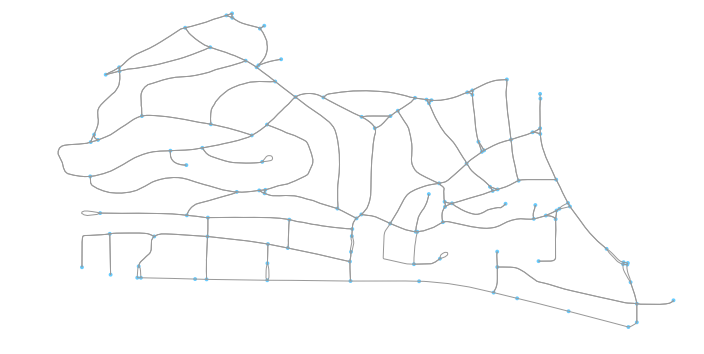

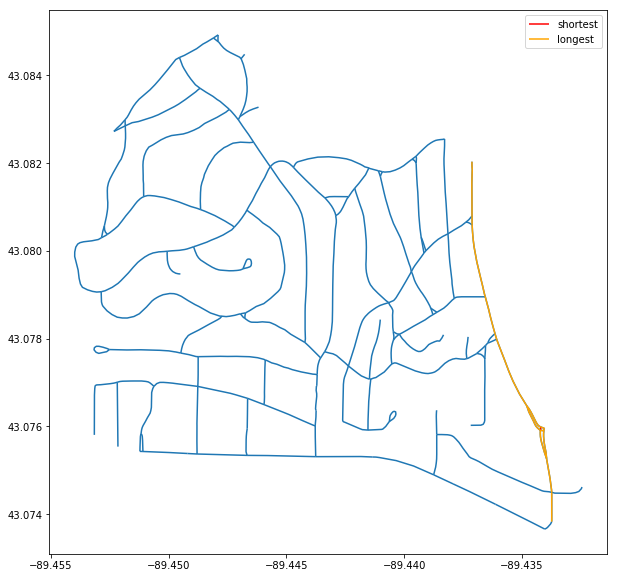

In [5]:
howlong('Shorewood Hills, WI')

Shortest road: Baruch Place (13.80 meters)
Longest road: Broadway (33808.79 meters)


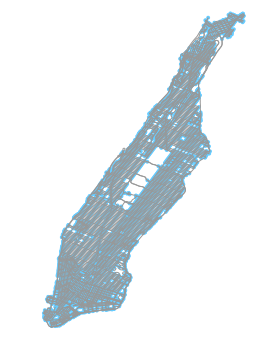

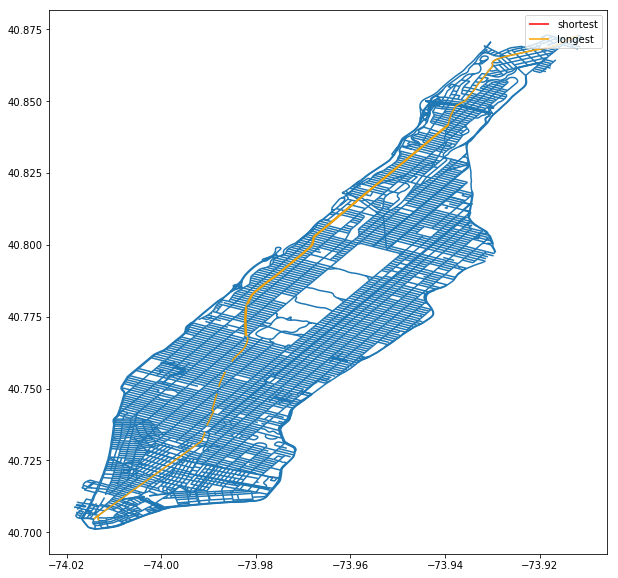

In [6]:
howlong('Manhattan, NY')

Shortest road: ['Seaview Avenue', 'Gateway Drive'] (13.39 meters)
Longest road: Belt Parkway (52746.24 meters)


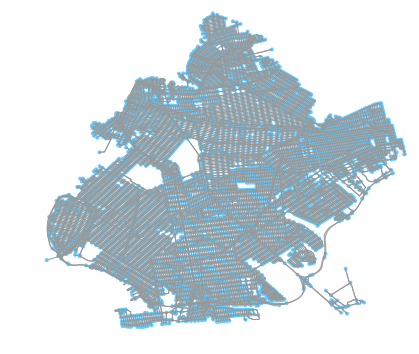

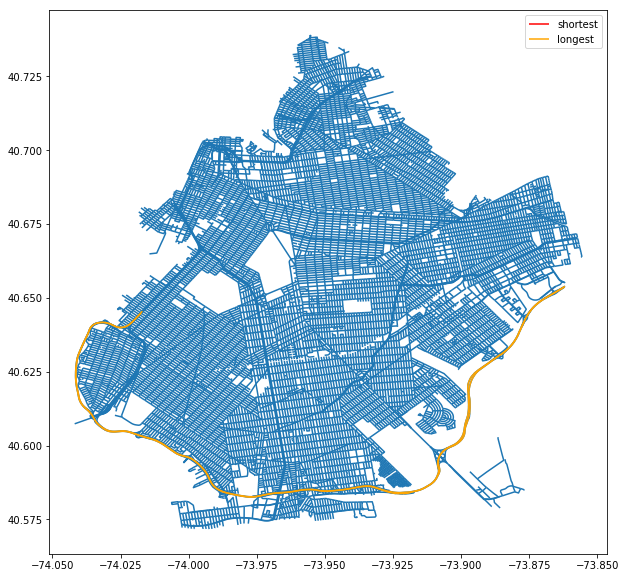

In [7]:
howlong('Brooklyn, NY')

Shortest road: ['環中東路一段', '環中東路二段'] (10.21 meters)
Longest road: 東西向快速公路 快官霧峰線 (74492.75 meters)


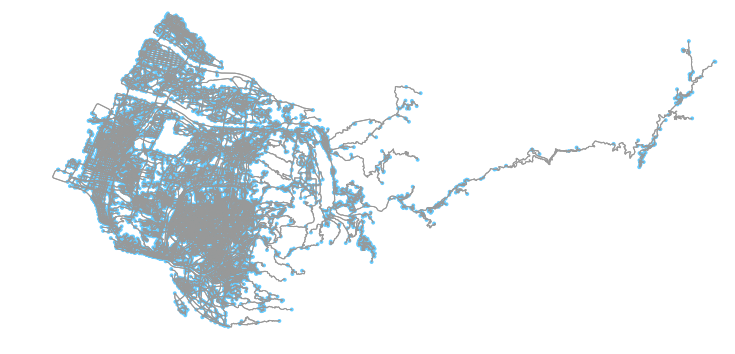

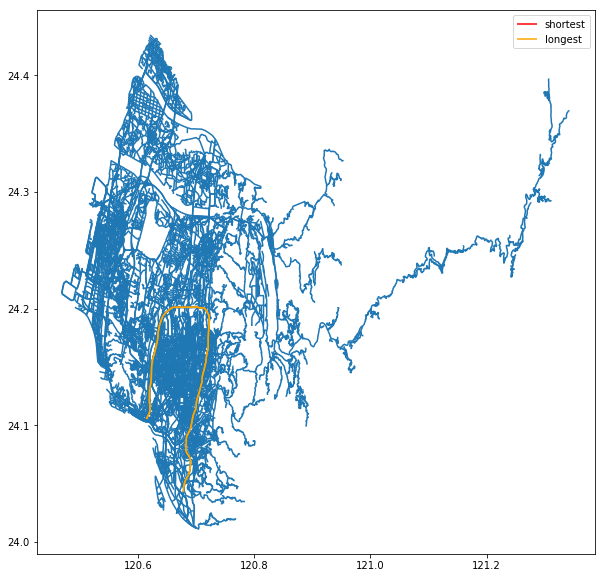

In [8]:
howlong('Taichung City, Taiwan')

Shortest road: 莊敬路6巷 (8.43 meters)
Longest road: 中山高速公路 (18066.64 meters)


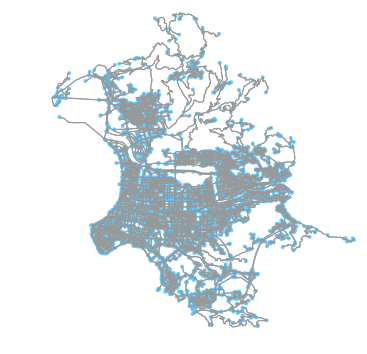

In [396]:
howlong('Taipei City, Taiwan')

### Issue 5: Outliers

1. Longest roads may end up being highways that does not really make sense in some urban problem context.
2. Shortest roads may end up being a short drive way, court, or even a tiny segment between two lanes of a crossing road.

**Consider:** subsetting road types and setting a boundary for reasonable road length

## 1.5 Visualize
Color the identified roads back onto the map:
1. Approach 1: rebuild a graph based on the dataframe. This requires we pull out node attributes as well and merge it with edge dataframe.
2. Approach 2: pass osmid back to the original graph and color it accordingly.

# 2. Sandbox for straightest/curviest road
## 2.1 Create a road segment dataframe (this time with shapefile)

In [397]:
import geopandas as gpd
from collections import Counter

In [398]:
# export as shapefile
ox.save_graph_shapefile(G, filename='nyc_sandbox')

In [399]:
G_shp = gpd.read_file('data/nyc_sandbox/edges/edges.shp')
G_shp.head()

,from,highway,key,lanes,length,name,oneway,osmid,to,geometry
0,42466688,residential,0,,42.74351200983276,Bushwick Court,False,5674905,42466686,"LINESTRING (-73.93881399999999 40.704263, -73...."
1,42513670,secondary,0,,42.38013813188918,Bushwick Avenue,False,347717621,42466686,"LINESTRING (-73.93881399999999 40.704263, -73...."
2,3539722830,secondary,0,,12.522123841951585,Bushwick Avenue,False,471943032,42466686,"LINESTRING (-73.93881399999999 40.704263, -73...."
3,42467811,residential,0,,79.15497487028533,Graham Avenue,False,221753943,42467807,"LINESTRING (-73.9423855 40.702346, -73.9424949..."
4,42467814,residential,0,,79.69358789807077,Graham Avenue,False,221753943,42467811,"LINESTRING (-73.94249499999999 40.703053, -73...."


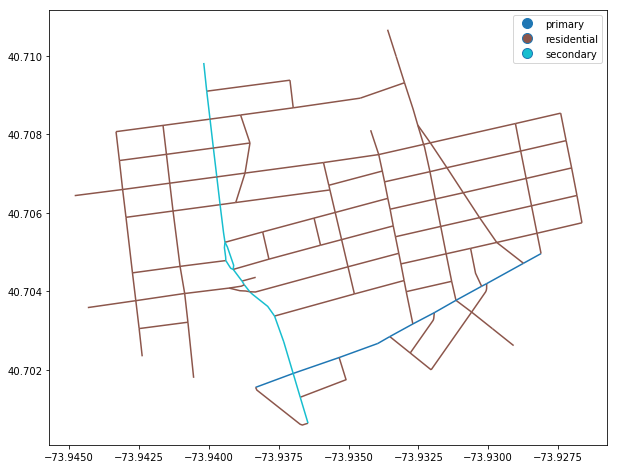

In [400]:
# quick examination of current graph
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111)
G_shp.plot(column='highway', legend=True, ax=ax)

## 2.2 Extract all segments of a single road

In [401]:
# method A: extract by road name groupby
roads = G_shp['name'].unique()
test1 = G_shp[G_shp['name'] == roads[10]]
test1

,from,highway,key,lanes,length,name,oneway,osmid,to,geometry
20,42504109,primary,0,,120.08147987936776,Flushing Avenue,False,221753936,42473650,"LINESTRING (-73.936982 40.70191, -73.9370965 4..."
45,42504145,primary,0,,125.10962820422014,Flushing Avenue,False,221753936,42479528,"LINESTRING (-73.9300554 40.7041988, -73.928738..."
46,42504129,primary,0,,17.063571072029312,Flushing Avenue,False,221753936,42479528,"LINESTRING (-73.9300554 40.7041988, -73.930237..."
55,42504116,primary,0,,78.22080473109985,Flushing Avenue,False,221753936,42486705,"LINESTRING (-73.93352299999999 40.702849, -73...."
56,42499797,primary,0,,40.992433602581826,Flushing Avenue,False,221753936,42486705,"LINESTRING (-73.93352299999999 40.702849, -73...."
72,42504129,primary,0,,87.02229337169685,Flushing Avenue,False,221753936,42490298,"LINESTRING (-73.931155 40.703773, -73.93023700..."
73,42504122,primary,0,,74.18424995165248,Flushing Avenue,False,221753936,42490298,"LINESTRING (-73.931155 40.703773, -73.9319307 ..."
112,42500468,primary,0,,123.38808909244743,Flushing Avenue,False,221753936,42499797,"LINESTRING (-73.93395099999999 40.702674, -73...."
114,42504109,primary,0,,145.8798014382331,Flushing Avenue,False,221753936,42500468,"LINESTRING (-73.936982 40.70191, -73.936871 40..."
131,42504122,primary,0,,72.12031769972224,Flushing Avenue,False,221753936,42504116,"LINESTRING (-73.932698 40.703171, -73.9319307 ..."


In [402]:
# method B: extract by osmid groupby
test2 = G_shp[G_shp['osmid'] == '221753936']
test2

,from,highway,key,lanes,length,name,oneway,osmid,to,geometry
20,42504109,primary,0,,120.08147987936776,Flushing Avenue,False,221753936,42473650,"LINESTRING (-73.936982 40.70191, -73.9370965 4..."
45,42504145,primary,0,,125.10962820422014,Flushing Avenue,False,221753936,42479528,"LINESTRING (-73.9300554 40.7041988, -73.928738..."
46,42504129,primary,0,,17.063571072029312,Flushing Avenue,False,221753936,42479528,"LINESTRING (-73.9300554 40.7041988, -73.930237..."
55,42504116,primary,0,,78.22080473109985,Flushing Avenue,False,221753936,42486705,"LINESTRING (-73.93352299999999 40.702849, -73...."
56,42499797,primary,0,,40.992433602581826,Flushing Avenue,False,221753936,42486705,"LINESTRING (-73.93352299999999 40.702849, -73...."
72,42504129,primary,0,,87.02229337169685,Flushing Avenue,False,221753936,42490298,"LINESTRING (-73.931155 40.703773, -73.93023700..."
73,42504122,primary,0,,74.18424995165248,Flushing Avenue,False,221753936,42490298,"LINESTRING (-73.931155 40.703773, -73.9319307 ..."
112,42500468,primary,0,,123.38808909244743,Flushing Avenue,False,221753936,42499797,"LINESTRING (-73.93395099999999 40.702674, -73...."
114,42504109,primary,0,,145.8798014382331,Flushing Avenue,False,221753936,42500468,"LINESTRING (-73.936982 40.70191, -73.936871 40..."
131,42504122,primary,0,,72.12031769972224,Flushing Avenue,False,221753936,42504116,"LINESTRING (-73.932698 40.703171, -73.9319307 ..."


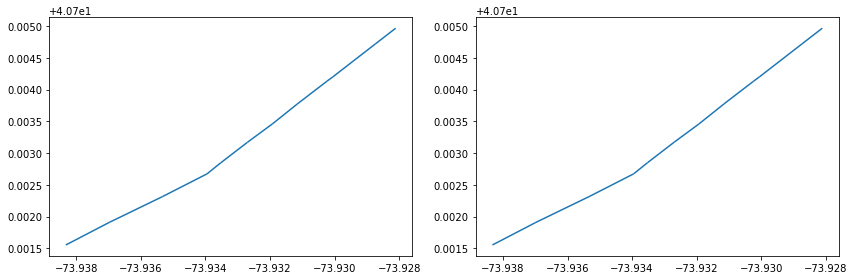

In [403]:
# plot road shape from both methods
fig = pl.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
test1.plot(ax=ax1)
ax2 = fig.add_subplot(122)
test2.plot(ax=ax2)

pl.tight_layout()

## 2.3 Find the terminal nodes of the road

In [404]:
# append all nodes together: Nodes On Road
nor = list(test1['from'].values) + list(test1['to'].values)
tdict = dict(Counter(nor))
tdict

{'42473650': 1,
 '42479528': 2,
 '42486705': 2,
 '42490298': 2,
 '42499797': 2,
 '42500468': 2,
 '42504109': 2,
 '42504116': 2,
 '42504122': 2,
 '42504129': 2,
 '42504145': 2,
 '42504156': 1}

In [405]:
# nodes that only occur once
tdf = pd.DataFrame(list(tdict.items()), columns=['node', 'count'])
tdf_sub = tdf[tdf['count']==1]
tdf_sub

,node,count
7,42504156,1
8,42473650,1


In [406]:
# read in nodes data shp as gpd
G_nodes = gpd.read_file('data/nyc_sandbox/nodes/nodes.shp')
G_nodes.head()

,osmid,geometry
0,42466686,POINT (-73.93881399999999 40.704263)
1,42466688,POINT (-73.938323 40.704359)
2,42467807,POINT (-73.9423855 40.702346)
3,42467811,POINT (-73.94249499999999 40.703053)
4,42467814,POINT (-73.94261400000001 40.703764)


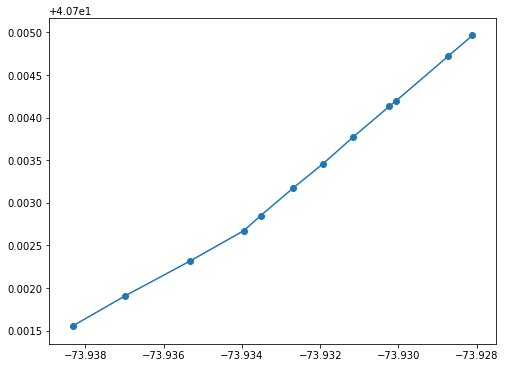

In [407]:
# pull out nodes that are on the road
G_nodes_or = G_nodes[list(map(lambda n: n in list(tdict.keys()), list(G_nodes['osmid'])))]
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)
test1.plot(ax=ax)
G_nodes_or.plot(ax=ax)

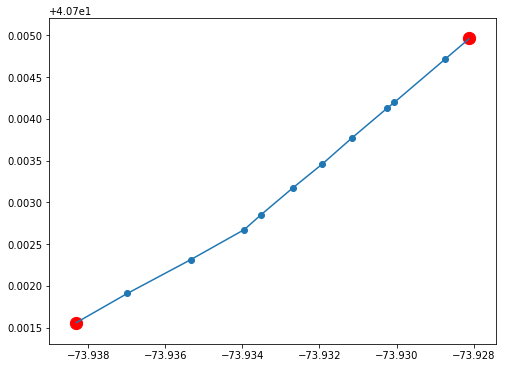

In [408]:
# plot terminals on the road
G_nodes_term = G_nodes[list(map(lambda n: n in list(tdf_sub['node'].values), list(G_nodes['osmid'])))]
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)
test1.plot(ax=ax)
G_nodes_or.plot(ax=ax)
G_nodes_term.plot(ax=ax, color='red', markersize=150)

## 2.4 Calculate circuity

In [409]:
from geopy.distance import vincenty
from shapely.geometry import Point

In [410]:
G_nodes_term

,osmid,geometry
11,42473650,POINT (-73.93832740000001 40.7015552)
74,42504156,POINT (-73.92810900000001 40.704964)


In [411]:
coord1 = list(G_nodes_term.iloc[0,1].coords)[0]
coord2 = list(G_nodes_term.iloc[1,1].coords)[0]
p1 = coord1[1], coord1[0]
p2 = coord2[1], coord2[0]

In [412]:
# calculate vincenty distance (more precise than great-circle)
dist_v = vincenty(p1, p2).meters

# calculate road distance
dist_r = test2['length'].astype('float', error='coerce').sum()

# calculate circuity
circ = dist_r / dist_v

# report result
print('road dist.: {:.2f}\nshortest dist.: {:.2f}\ncircuity: {:.5f}'.format(dist_r, dist_v, circ))

road dist.: 943.78
shortest dist.: 942.89
circuity: 1.00094


## 2.5 Build function

In [367]:
def howcurve(place, ntype='drive'):
    """
    Find the straightest and curviest roads by name in a given geographical area in OSM.
    
    Args:
        1. place: a string of place name
        2. ntype: network type (not tested yet)
    Return:
        1. name and circuity info of the straightest road
        2. name and circuity info of the curviest road
        3. network graph plot of given place
    """
    
    # try different API query results
    try:
        G = ox.graph_from_place(place, network_type='drive', which_result=1)
    except:
        G = ox.graph_from_place(place, network_type='drive', which_result=2)
    
    # save and read as .shp file
    ox.save_graph_shapefile(G, filename='howcurve')
    G_edges = gpd.read_file('data/howcurve/edges/edges.shp')
    G_nodes = gpd.read_file('data/howcurve/nodes/nodes.shp')
    
    # extract road names
    roads = list(G_edges['name'].unique())
    roads.remove('') ### remove messy segements without names ###
    rnames = []
    dist_v = []
    dist_r = []
    circuity = []
    
    # calculate circuity for each road
    for i,r in enumerate(roads):
        df_road = G_edges[G_edges['name'] == roads[i]]
        nor = list(df_road['from'].values) + list(df_road['to'].values)
        tdict = dict(Counter(nor))
        tdf = pd.DataFrame(list(tdict.items()), columns=['node', 'count'])
        tdf_sub = tdf[tdf['count']==1]

        if len(tdf_sub) != 2:
            
            continue ### skip roads with more than two terminal nodes for now ###

        else:
            
            G_nodes_term = G_nodes[list(map(lambda n: n in list(tdf_sub['node'].values), list(G_nodes['osmid'])))]
            coord1 = list(G_nodes_term.iloc[0,:]['geometry'].coords)[0]
            coord2 = list(G_nodes_term.iloc[1,:]['geometry'].coords)[0]
            p1 = coord1[1], coord1[0]
            p2 = coord2[1], coord2[0]

            d_v = vincenty(p1, p2).meters
            d_r = df_road['length'].astype('float', error='coerce').sum()
            circ = d_r / d_v

            rnames.append(r)
            dist_v.append(d_v)
            dist_r.append(d_r)
            circuity.append(circ)

    # create a dataframe with circuity data
    df_circ = pd.DataFrame({'name': rnames,
                            'dist_v': dist_v,
                            'dist_r': dist_r,
                            'circuity': circuity})

    # calculate straightest and curviest roads
    straight = df_circ.sort_values('circuity', ascending=True).head(1).iloc[0]
    curve = df_circ.sort_values('circuity', ascending=False).head(1).iloc[0]
    
    # output
    print('Straightest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\ncircuity: {:.5f}\n'.format(straight['name'], straight['dist_r'], straight['dist_v'], straight['circuity']))
    print('Curviest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\ncircuity: {:.5f}\n'.format(curve['name'], curve['dist_r'], curve['dist_v'], curve['circuity']))

    #ox.plot_graph(G);
    fig, ax = pl.subplots(figsize=(10,10))
    G_edges.plot(ax=ax)
    G_edges[G_edges['name'] == straight['name']].plot(color='red', ax=ax, label='straightest')
    G_edges[G_edges['name'] == curve['name']].plot(color='orange', ax=ax, label='curviest')
    pl.legend(fontsize='medium')
    pl.show()

Straightest road: DeKalb Avenue
road dist.: 13.56
shortest dist.: 13.60
circuity: 0.99743

Curviest road: Myrtle Avenue
road dist.: 169.16
shortest dist.: 14.93
circuity: 11.33029



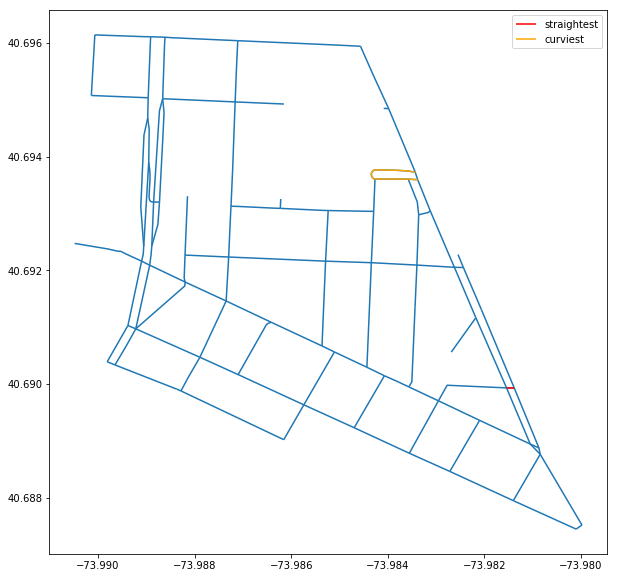

In [368]:
howcurve('Downtown Brooklyn, NY')

Straightest road: Wood Close
road dist.: 17.02
shortest dist.: 17.04
circuity: 0.99894

Curviest road: ['Sunset Drive', 'Blackhawk Drive']
road dist.: 268.71
shortest dist.: 136.93
circuity: 1.96242



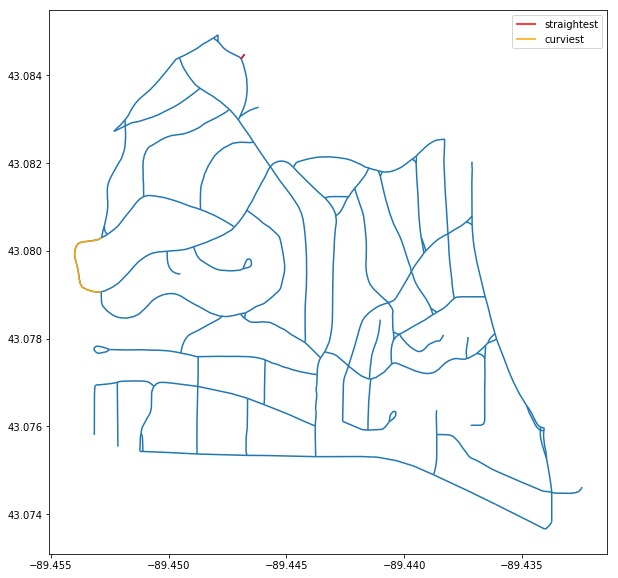

In [372]:
howcurve('Shorewood Hills, WI')

Straightest road: 莊敬路6巷
road dist.: 8.43
shortest dist.: 8.45
circuity: 0.99827

Curviest road: 松壽路
road dist.: 1474.38
shortest dist.: 17.90
circuity: 82.36183



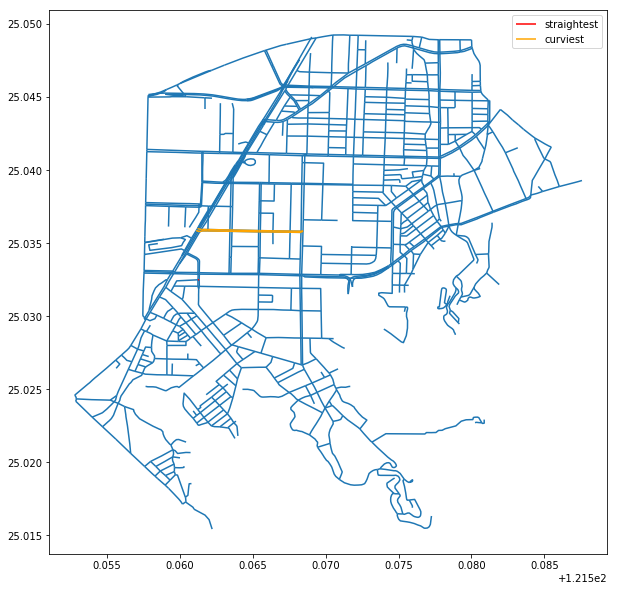

In [369]:
howcurve('Xinyi, Taipei City, Taiwan')

Straightest road: Stell Place
road dist.: 127.59
shortest dist.: 127.92
circuity: 0.99745

Curviest road: Edward L. Grant Highway
road dist.: 1875.52
shortest dist.: 33.05
circuity: 56.75563



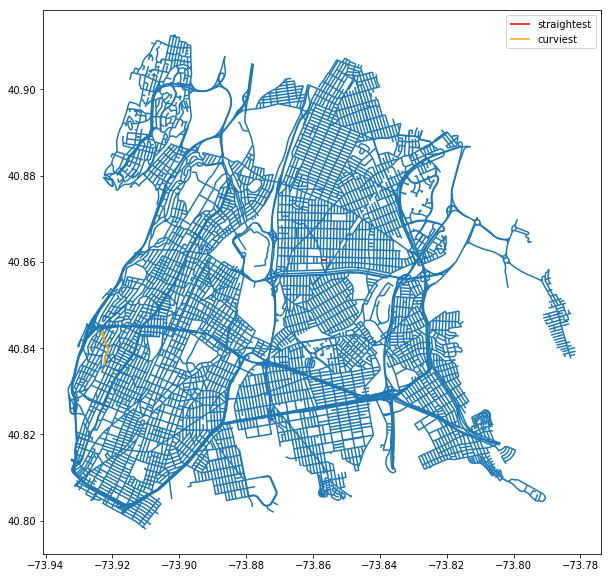

In [370]:
howcurve('Bronx, NY')

Straightest road: Carrer d'Estefania de Requesens
road dist.: 92.13
shortest dist.: 92.37
circuity: 0.99741

Curviest road: ['Carrer de Felip II', 'Pont de Bac de Roda']
road dist.: 429.20
shortest dist.: 5.83
circuity: 73.60424



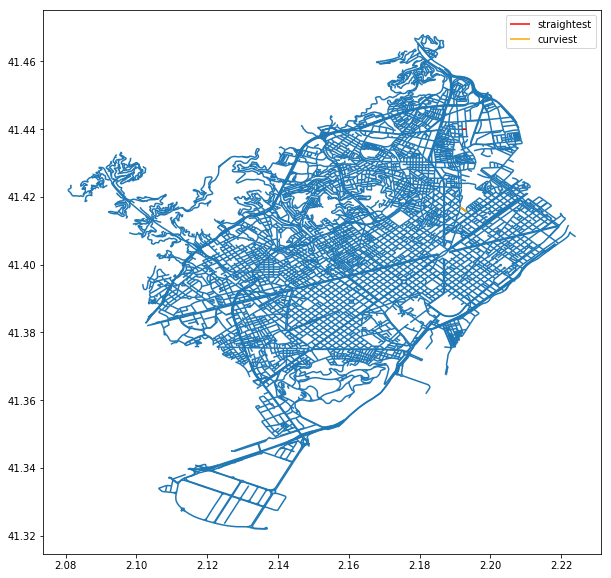

In [371]:
howcurve('Barcelona')

### Issue 6: Preliminary Function  for Circuity

1. The method is working, but needs to be modified in order to get meaningful results. For example, some roads have separate lanes in the graph that caused their lengths to be doubled; also, some straightest road tend to be the shortest segment, even having a circuity lower than 1 (which is theoretically not possible but may happen due to data quality).
2. Can only deal with roads with two terminal nodes right now. Multiple single node situations include: loop, parallel lanes, forks, etc.
2. Codes need to be optimized.
3. Display the identified roads on the graph plot.

# > > > Notebook ends here < < <

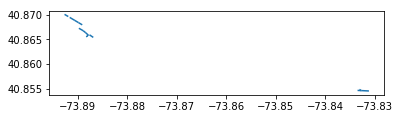

In [279]:
# issues with grouping by road name
df_road.plot()

In [69]:
# lens = list(nx.get_edge_attributes(G2, 'length').values())
# max(lens)

305.40620395441033

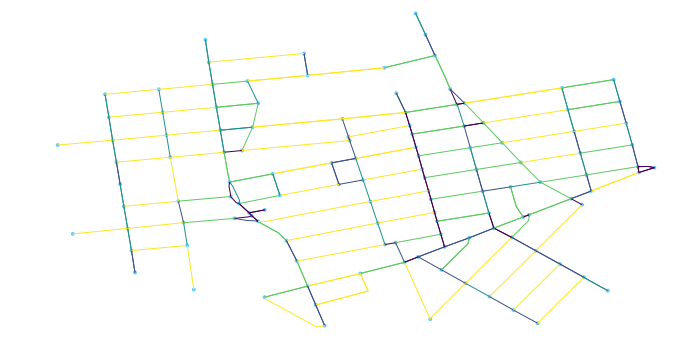

(<matplotlib.figure.Figure at 0x11865e0b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118758898>)

In [123]:
# ec = ox.get_edge_colors_by_attr(G, attr='length')
# ox.plot_graph(G, edge_color=ec)

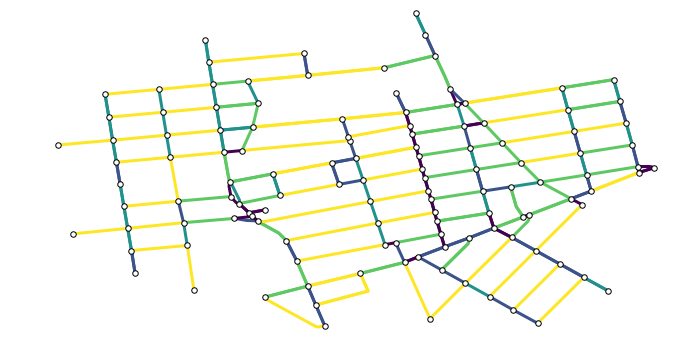

In [80]:
# fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=30, 
#                             node_zorder=3, edge_color=ec, edge_linewidth=3)

In [ ]:
# ox.graph_from_place('Manhattan, NY', network_type='drive', which_result=2)
# ox.plot_graph(ox.graph_from_place('Taipei, Taiwan', which_result=2))

# city = ox.gdf_from_place('Berkeley, CA')
# ox.plot_shape(ox.project_gdf(city))

In [55]:
# str(G_shp['geometry'][31])

'LINESTRING (-73.9394224 40.7052512, -73.9394729 40.7054909, -73.9395865 40.7061438, -73.939598 40.70621)'

In [56]:
# G_shp = G_shp.groupby(by='name').sum().reset_index()
# G_shp.drop(['node_a', 'node_b', 'oneway'], axis=1, inplace=True)
# G_shp.head()

,name,from,highway,key,lanes,length,oneway,osmid,to
0,Boerum Street,4246782342476791424767934247680542476825,residentialresidentialresidentialresidentialre...,00000,,143.07427910467536143.0739956340639847.6821654...,TrueTrueTrueTrueTrue,468171764681717646817176468171765676562,4247679142476793424768054247681142476829
1,Bogart Street,4247682942487173425011524249091142518776424963...,residentialresidentialresidentialresidentialre...,0000000000000,,47.9320525810434231.31344166740340347.84067618...,TrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTr...,5680133568013356801335680133568013356801335680...,4249637742476829424871734251878142490911299529...
2,Bushwick Avenue,4251367035397228304249636135397257704251112342...,secondarysecondarysecondarysecondarysecondarys...,00000000000000000,444,42.3801381318891812.52212384195158579.34137505...,FalseFalseFalseFalseFalseFalseFalseFalseFalseF...,3477176214719430322216891422216891425519516652...,4246668642466686424767934247679342485763424963...
3,Bushwick Court,42466688,residential,0,,42.74351200983276,False,5674905,42466686
4,Bushwick Place,424768054249636742523550,residentialresidentialresidential,000,,87.9665791669237586.5817473011263384.188835373...,TrueTrueTrue,5682188276050426276050425,424963674252355042529171
